In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import os
import pandas as pd
from dotenv import load_dotenv
import numpy as np

import statsmodels.api as sm


import os
import sys

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Adjust so all columns in dataframe are shown
pd.set_option("display.max_columns", None)

In [3]:
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## Get data

In [4]:
df = pd.read_sql_query(
    """
    SELECT
        *
    FROM
        block_metrics
    """,
    postgres_uri_mp,
)

print(f"Number of rows: {len(df)}")

df.head()

Number of rows: 2383255


,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf
0,16086038,0x0002e63328169d7feea121f1e32e4f620abf0352,1,1,0,0.436709,True,0.025768,[010_076],[0.4490580820270038],1.234886e-02,1.234886e-02,1.234886e-02,[010_076],[0.4490580820270038],1.234886e-02,1.234886e-02,1.234886e-02
1,16846140,0x000c0d31f6b7cecde4645eef0c4ec6a492659d62,1,0,1,0.000042,True,0.268579,[034_136],[4.065739289557394e-05],9.179864e-07,9.179864e-07,9.179864e-07,[034_136],[4.065739289557394e-05],9.179864e-07,9.179864e-07,9.179864e-07
2,15681803,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387,1,0,1,1346.324500,False,0.000000,[050_083],[1345.2917761129263],1.032724e+00,1.032724e+00,1.032724e+00,[050_083],[1345.2917761129263],1.032724e+00,1.032724e+00,1.032724e+00
3,15681898,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387,1,0,1,1345.291776,False,0.000000,[037_054],[1344.0439426492394],1.247833e+00,1.247833e+00,1.247833e+00,[037_054],[1344.0439426492394],1.247833e+00,1.247833e+00,1.247833e+00
4,15681920,0x7bea39867e4169dbe237d55c8242a8f2fcdcc387,1,0,1,1344.043943,True,0.093772,[073_146],[1343.9110399324309],1.329027e-01,1.329027e-01,1.329027e-01,[073_146],[1343.9110399324309],1.329027e-01,1.329027e-01,1.329027e-01


## Descriptive statistics

### Number of swaps in each pool-block pair

In [5]:
count_df = df.groupby("num_transactions").block_number.count().sort_index()
count_df = count_df[count_df.index < 50]
counts: np.ndarray = count_df.to_numpy()
index = count_df.index.to_numpy()

print(counts)
print(index)

[2125819  183225   50512   13833    5048    2188    1038     496     346
     198     142     101      63      66      43      36      22      15
      11      11       7       3       2       4       3       2       4
       1       3       2       1       1       1       3       2]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 27 28 29 30 31 32 33 34 35 38 44]


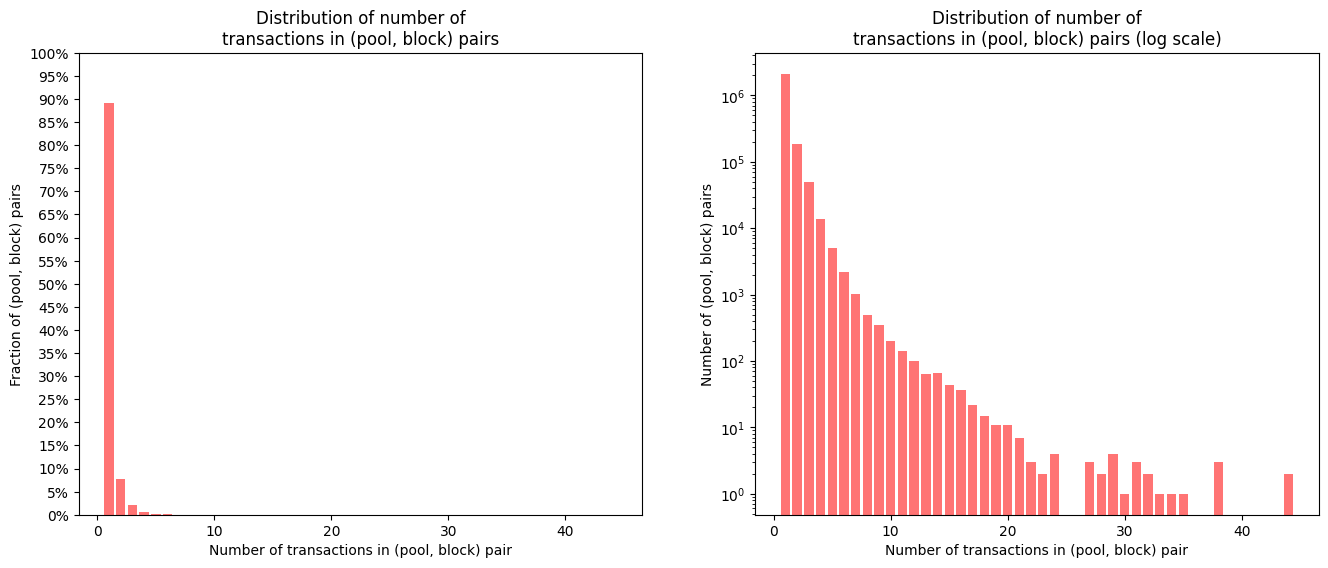

In [6]:
normalized = counts / counts.sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_col = "#FF7474"

ax1.bar(index, normalized, color=bar_col)
ax1.set_xlabel("Number of transactions in (pool, block) pair")
ax1.set_ylabel("Fraction of (pool, block) pairs")
ax1.set_title("Distribution of number of\ntransactions in (pool, block) pairs")
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.set_yticks(np.arange(0, 1.05, 0.05))

ax2.bar(index, counts, color=bar_col)
ax2.set_yscale("log")
ax2.set_xlabel("Number of transactions in (pool, block) pair")
ax2.set_ylabel("Number of (pool, block) pairs")
ax2.set_title("Distribution of number of\ntransactions in (pool, block) pairs (log scale)");

### Share of blocks, swaps, and pools created through MEV-boost auctions

Text(0.5, 1.0, 'Number of unique pool addresses')

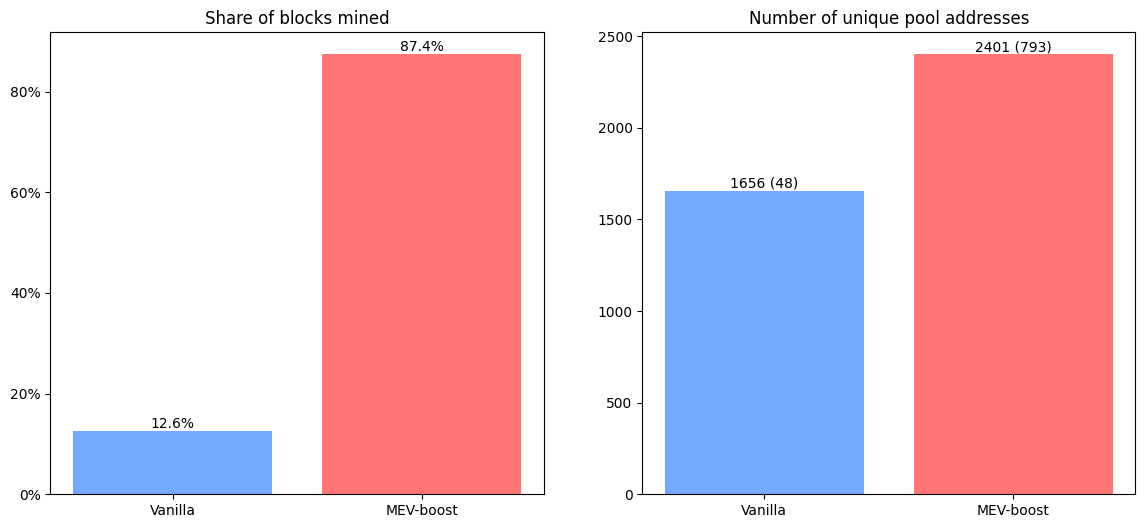

In [7]:
# Plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
bar_cols = ["#74ABFF", "#FF7474"]

# First plot
block_share = df.groupby("mev_boost").block_number.nunique().sort_index()
bars = ax1.bar(["Vanilla", "MEV-boost"], block_share.values / block_share.sum(), color=bar_cols)
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(height), ha='center', va='bottom')

ax1.set_title("Share of blocks mined")

# Second plot
pool_count = df.groupby("mev_boost").pool_address.nunique().sort_index()
bars = ax2.bar(["Vanilla", "MEV-boost"], pool_count.values, color=bar_cols)

only_vanilla = set(df[df.mev_boost == False].pool_address.unique())
only_mev = set(df[df.mev_boost == True].pool_address.unique())
only_vanilla_count = len(only_vanilla - only_mev)
only_mev_count = len(only_mev - only_vanilla)

# Add the values atop the bars
for bar, only in zip(bars, [only_vanilla_count, only_mev_count]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f"{height} ({only})", ha='center', va='bottom')

ax2.set_title("Number of unique pool addresses")


In [8]:
def get_p_value(sums, counts):
    # Assuming group1 and group2 are the two groups with binary values (0 or 1)
    count1 = sums.loc[False]
    count2 = sums.loc[True]
    n1 = counts.loc[False]
    n2 = counts.loc[True]

    _, p_value = sm.stats.proportions_ztest([count1, count2], [n1, n2])

    return p_value

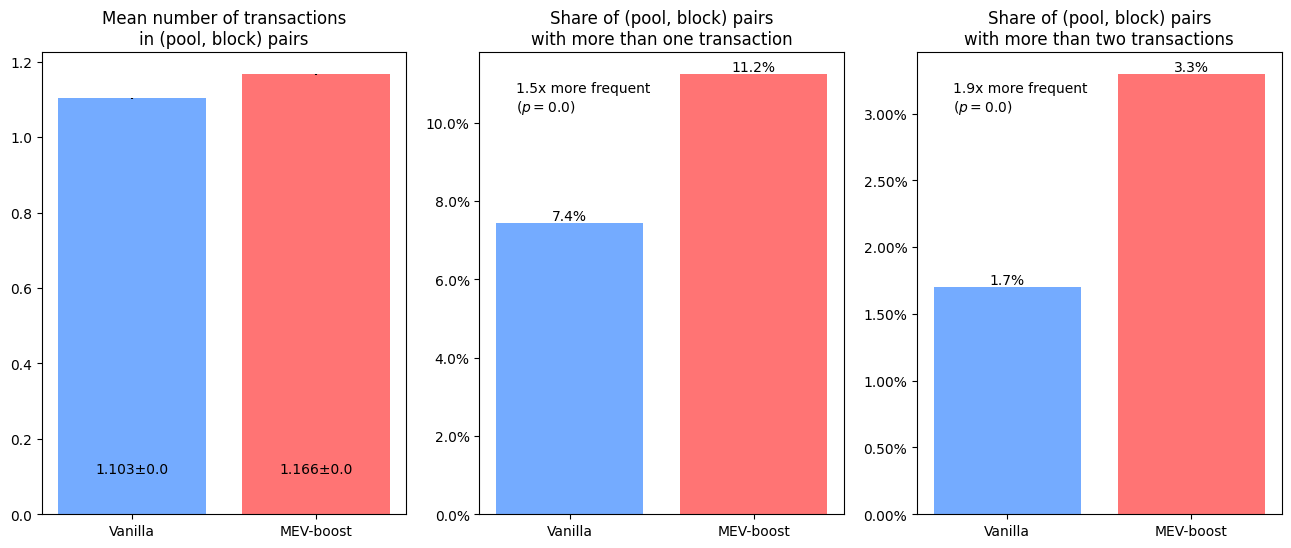

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# First plot
n_transaction_mean = df.groupby("mev_boost").num_transactions.mean().sort_index()
n_transaction_std = df.groupby("mev_boost").num_transactions.std().sort_index()
n_transaction_sem = df.groupby("mev_boost").num_transactions.sem().sort_index()

bars = ax1.bar(["Vanilla", "MEV-boost"], n_transaction_mean.values, color=bar_cols, yerr=n_transaction_sem.values)

# Add the values at the base of the bars
for bar, mean, std in zip(bars, n_transaction_mean.values, n_transaction_sem.values):
    ax1.text(bar.get_x() + bar.get_width() / 2, 0.1, f"{mean:.3f}±{std:.1f}", ha='center', va='bottom')

ax1.set_title("Mean number of transactions\nin (pool, block) pairs")

# Second plot
share_more_than_one_mean = df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.mean().sort_index()
sum_more_than_one = df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.sum().sort_index()
count_more_than_one = df.assign(more_than_one=df.num_transactions > 1).groupby("mev_boost").more_than_one.count().sort_index()
p_value = get_p_value(sum_more_than_one, count_more_than_one)

bars = ax2.bar(["Vanilla", "MEV-boost"], share_more_than_one_mean.values, color=bar_cols)
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(height), ha='center', va='bottom')

ax2.set_title("Share of (pool, block) pairs\nwith more than one transaction")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_one_mean.values[1] / share_more_than_one_mean.values[0]
ax2.text(0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha='left', va='center', transform=ax2.transAxes)

# Third plot
share_more_than_two_mean = df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.mean().sort_index()
sum_more_than_two = df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.sum().sort_index()
count_more_than_two = df.assign(more_than_two=df.num_transactions > 2).groupby("mev_boost").more_than_two.count().sort_index()
p_value = get_p_value(sum_more_than_two, count_more_than_two)

bars = ax3.bar(["Vanilla", "MEV-boost"], share_more_than_two_mean.values, color=bar_cols)
ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Add the values atop the bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(height), ha='center', va='bottom')

ax3.set_title("Share of (pool, block) pairs\nwith more than two transactions")

# Add text saying how many times more frequent it is in the MEV-boosted blocks
x_more_freq = share_more_than_two_mean.values[1] / share_more_than_two_mean.values[0]
ax3.text(0.1, 0.9, f"{x_more_freq:.1f}x more frequent\n($p={p_value}$)", ha='left', va='center', transform=ax3.transAxes);


In [10]:
from scipy.stats import ttest_ind

# Split the data into two groups based on MEV-boost (true/false)
group1 = df[df['mev_boost'] == True]['num_transactions']
group2 = df[df['mev_boost'] == False]['num_transactions']

# Perform the two-sample t-test
t_stat, p_value = ttest_ind(group1, group2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-statistic: 52.93996244996082
P-value: 0.0


## Statistics on the Metric

In [11]:
df_metric = df[df.num_transactions > 1]


df_metric = df_metric.assign(
    metric_l1=df_metric.realized_l1 / df_metric.volume_heur_l1,
    metric_l2=df_metric.realized_l2 / df_metric.volume_heur_l2,
    metric_linf=df_metric.realized_linf / df_metric.volume_heur_linf,
)

# Take out extreme outliers
outlier_thresh = 1e3
cnt_before = len(df_metric)
df_metric = df_metric[(df_metric.metric_l1 < outlier_thresh) & ((df_metric.metric_l1 > 1 / outlier_thresh))]
cnt_after = len(df_metric)
print(f"Removed {cnt_before - cnt_after} outliers ({(cnt_before - cnt_after) / cnt_before:.3%})")

df_metric_2 = df_metric[df_metric.num_transactions > 2]

df_metric_2 = df_metric_2.assign(
    metric_l1=df_metric_2.realized_l1 / df_metric_2.volume_heur_l1,
    metric_l2=df_metric_2.realized_l2 / df_metric_2.volume_heur_l2,
    metric_linf=df_metric_2.realized_linf / df_metric_2.volume_heur_linf,
)

df_metric.head()

Removed 102 outliers (0.040%)


,block_number,pool_address,num_transactions,n_buys,n_sells,baseline_price,mev_boost,mev_boost_amount,realized_order,realized_prices,realized_l1,realized_l2,realized_linf,volume_heur_order,volume_heur_prices,volume_heur_l1,volume_heur_l2,volume_heur_linf,metric_l1,metric_l2,metric_linf
67,16835809,0x1512639d5da6968a041a5ba0e333241e431c3413,2,0,2,160398.684177,True,0.044626,"[015_052, 016_059]","[157173.32638172718, 155124.42721070355]",8499.614761,6182.290793,5274.256966,"[016_059, 015_052]","[158285.54619987364, 155123.93658649703]",7387.885567,5682.280726,5274.747590,1.150480,1.087995,0.999907
103,16901934,0x0004cd8474e882278e32e584699090be496f410e,3,1,2,22.223323,True,0.023309,"[002_013, 003_017, 004_023]","[21.76735919356596, 21.295042031416727, 21.727...",1.880530,1.147130,0.928280,"[004_023, 002_013, 003_017]","[22.664564064766004, 22.195326798040053, 21.70...",0.983555,0.678233,0.514318,1.911973,1.691350,1.804878
109,16836655,0x1512639d5da6968a041a5ba0e333241e431c3413,2,0,2,164558.460459,True,0.031925,"[003_015, 004_019]","[159591.41595336117, 157135.9095589004]",12389.595405,8931.169743,7422.550900,"[004_019, 003_015]","[161987.65648039506, 157137.3415375578]",9991.922899,7853.791386,7421.118921,1.239961,1.137179,1.000193
131,16838668,0x1512639d5da6968a041a5ba0e333241e431c3413,2,0,2,141029.709555,True,0.063902,"[000_002, 001_006]","[138168.3331745473, 131785.62727960924]",12105.458655,9676.803806,9244.082275,"[000_002, 001_006]","[138168.3331745473, 131785.62727960924]",12105.458655,9676.803806,9244.082275,1.000000,1.000000,1.000000
133,16838845,0x1512639d5da6968a041a5ba0e333241e431c3413,3,1,2,134903.113549,True,0.044751,"[002_002, 003_006, 004_012]","[132168.2365428284, 126192.6891957932, 128858....",17490.055420,10949.433606,8710.424354,"[004_012, 002_002, 003_006]","[137658.7327177345, 134839.24117187402, 128683...",9039.454167,6803.341215,6219.962621,1.934857,1.609420,1.400398


### Metric Sanity Check

In [12]:
# Define the metrics to compare
realized_metrics = ['realized_l1', 'realized_l2', 'realized_linf']
volume_metrics = ['volume_heur_l1', 'volume_heur_l2', 'volume_heur_linf']

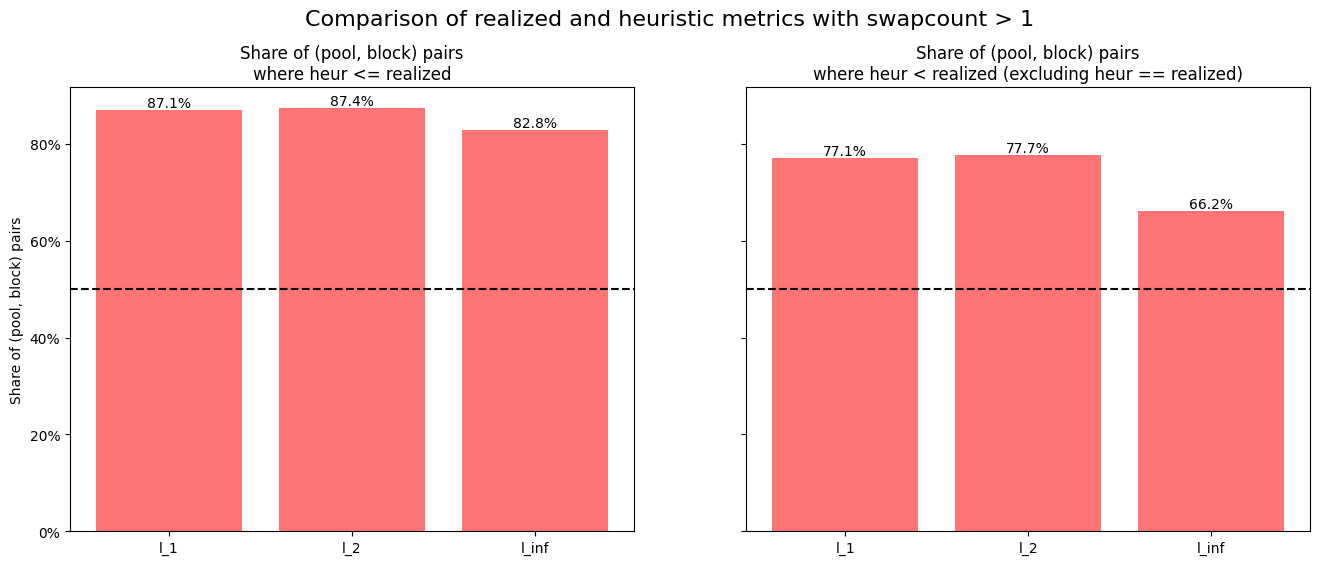

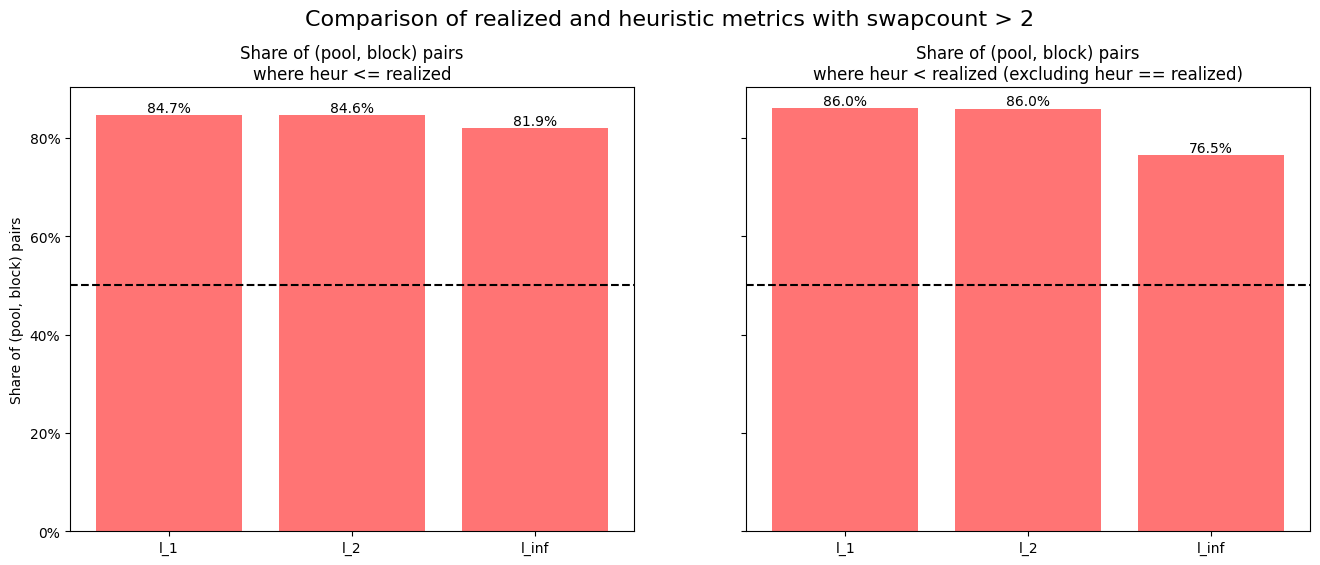

In [13]:
def plot_metric_comparison(df, ax1, ax2):
    differences = df[realized_metrics].values - df[volume_metrics].values

    diff_df = pd.DataFrame(differences, columns=['l_1', 'l_2', 'l_inf'])

    diff_df_no_zeros = diff_df[(diff_df != 0).all(1)]

    # Plot the rate each metric is positive

    bars = ax1.bar(
        x=diff_df.columns,
        height=(diff_df >= 0).mean(),
        color=bar_col,
    )

    ax1.set_title("Share of (pool, block) pairs\nwhere heur <= realized")
    ax1.set_ylabel("Share of (pool, block) pairs")
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(height), ha='center', va='bottom')

    # Add horizontal line at 50%
    ax1.axhline(0.5, color='black', linestyle='--')


    bars = ax2.bar(
        x=diff_df_no_zeros.columns,
        height=(diff_df_no_zeros >= 0).mean(),
        color=bar_col,
    )

    ax2.set_title("Share of (pool, block) pairs\nwhere heur < realized (excluding heur == realized)")
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

    # Add the values atop the bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, '{:.1%}'.format(height), ha='center', va='bottom');

    # Add horizontal line at 50%
    ax2.axhline(0.5, color='black', linestyle='--');



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 1", fontsize=16);
plot_metric_comparison(df_metric, ax1, ax2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plt.subplots_adjust(top=0.85)
fig.suptitle("Comparison of realized and heuristic metrics with swapcount > 2", fontsize=16);
plot_metric_comparison(df_metric_2, ax1, ax2)



### Between-group comparison

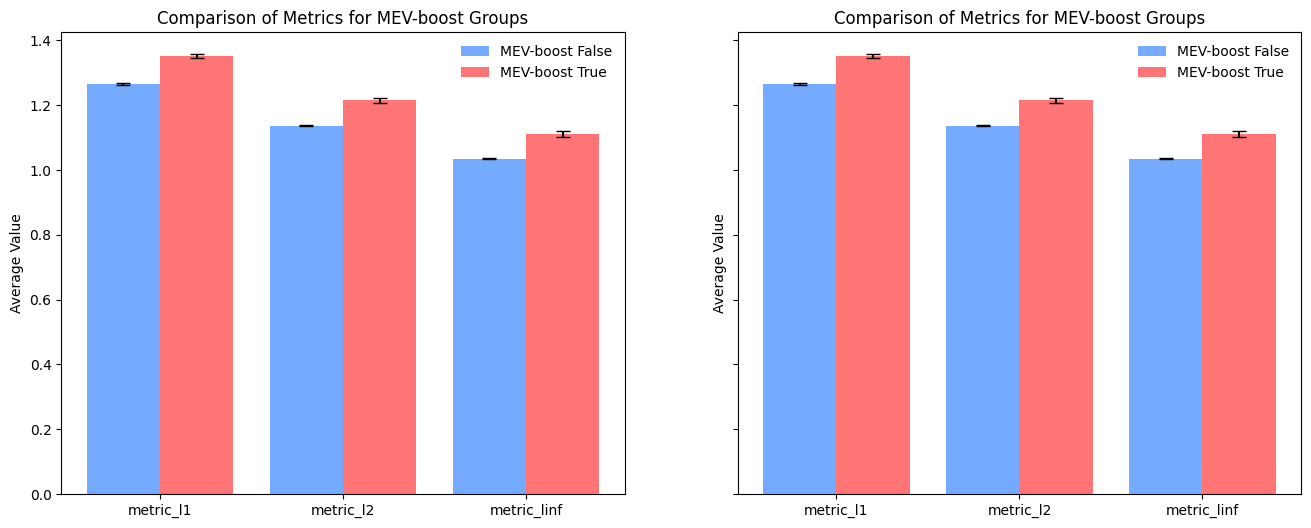

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

def plot_between_group_comp(df, ax):
    # Split the DataFrame into two groups based on MEV-boost (true/false)
    grouped = df_metric.groupby('mev_boost')

    # Define the metrics
    metrics = ['metric_l1', 'metric_l2', 'metric_linf']

    # Store means and standard errors for both groups
    means = []
    errors = []

    # Calculate the means and standard errors for each metric
    for metric in metrics:
        mean = grouped[metric].mean()
        error = grouped[metric].sem()  # Standard error of the mean
        means.append(mean)
        errors.append(error)

    # Convert to a NumPy array for easy indexing
    means = np.array(means)
    errors = np.array(errors)

    # Plot the means with error bars
    width = 0.4  # Width of the bars
    x = np.arange(len(metrics))

    for i, label in enumerate(['MEV-boost False', 'MEV-boost True']):
        ax.bar(x + i * width, means[:, i], width=width, yerr=errors[:, i], capsize=5, label=label, color=bar_cols[i])

    ax.set_ylabel('Average Value')
    ax.set_title('Comparison of Metrics for MEV-boost Groups')
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(metrics)
    ax.legend(frameon=False)


plot_between_group_comp(df_metric, ax1)
plot_between_group_comp(df_metric_2, ax2)

### Within MEV-boost group comparison

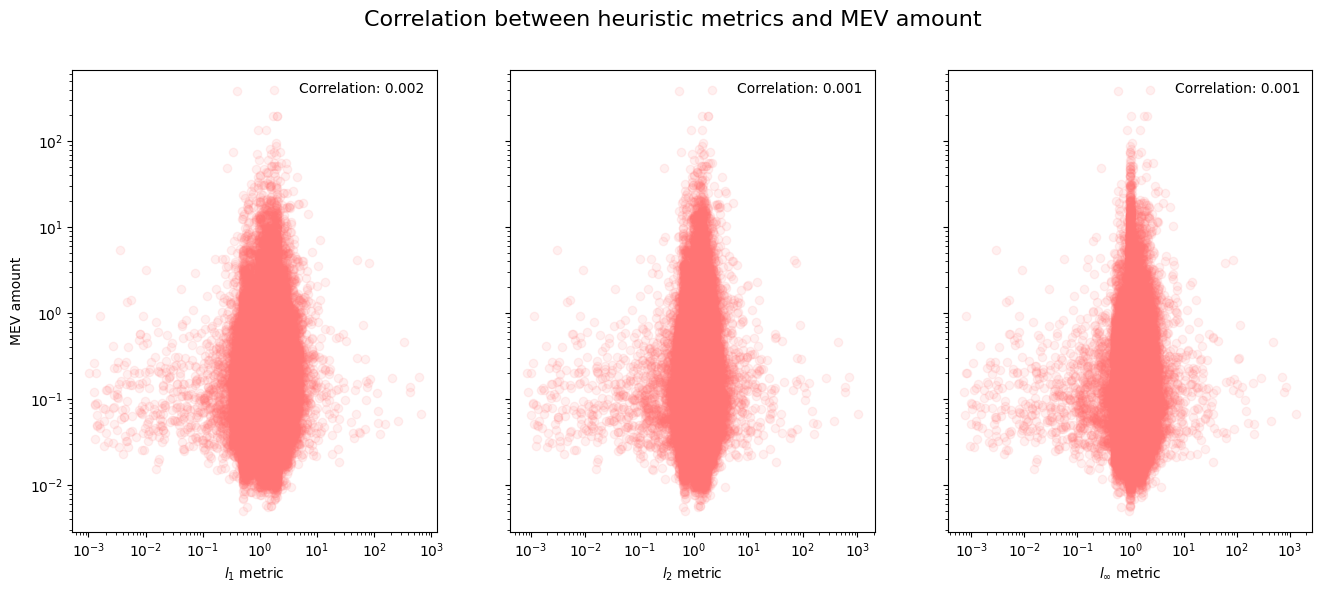

In [15]:
def plot_correlations(df, ax1, ax2, ax3):
    # df_metric_mev = df_metric_mev[(df_metric_mev.metric_l1 < 100) & (df_metric_mev.mev_boost_amount < 100)]

    l1 = df_metric_mev.metric_l1
    l2 = df_metric_mev.metric_l2
    linf = df_metric_mev.metric_linf
    mev_amount = df_metric_mev.mev_boost_amount

    # Calculate the correlation between the metrics and MEV amount
    corr_l1 = l1.corr(mev_amount)
    corr_l2 = l2.corr(mev_amount)
    corr_linf = linf.corr(mev_amount)

    ax1.scatter(l1, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_l1:.3f}")
    ax1.loglog()
    ax1.set_xlabel("$l_1$ metric")
    ax1.set_ylabel("MEV amount")
    ax1.legend(frameon=False)

    ax2.scatter(l2, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_l2:.3f}")
    ax2.loglog()
    ax2.set_xlabel("$l_2$ metric")
    ax2.legend(frameon=False)

    ax3.scatter(linf, mev_amount, alpha=0.1, color=bar_cols[1], label=f"Correlation: {corr_linf:.3f}")
    ax3.loglog()
    ax3.set_xlabel("$l_{\infty}$ metric")
    ax3.legend(frameon=False);


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
df_metric_mev = df_metric[df_metric.mev_boost == True]
df_metric_mev = df_metric_mev[df_metric_mev.metric_l1 != 1]

fig.suptitle("Correlation between heuristic metrics and MEV amount", fontsize=16)
plot_correlations(df_metric_mev, ax1, ax2, ax3)


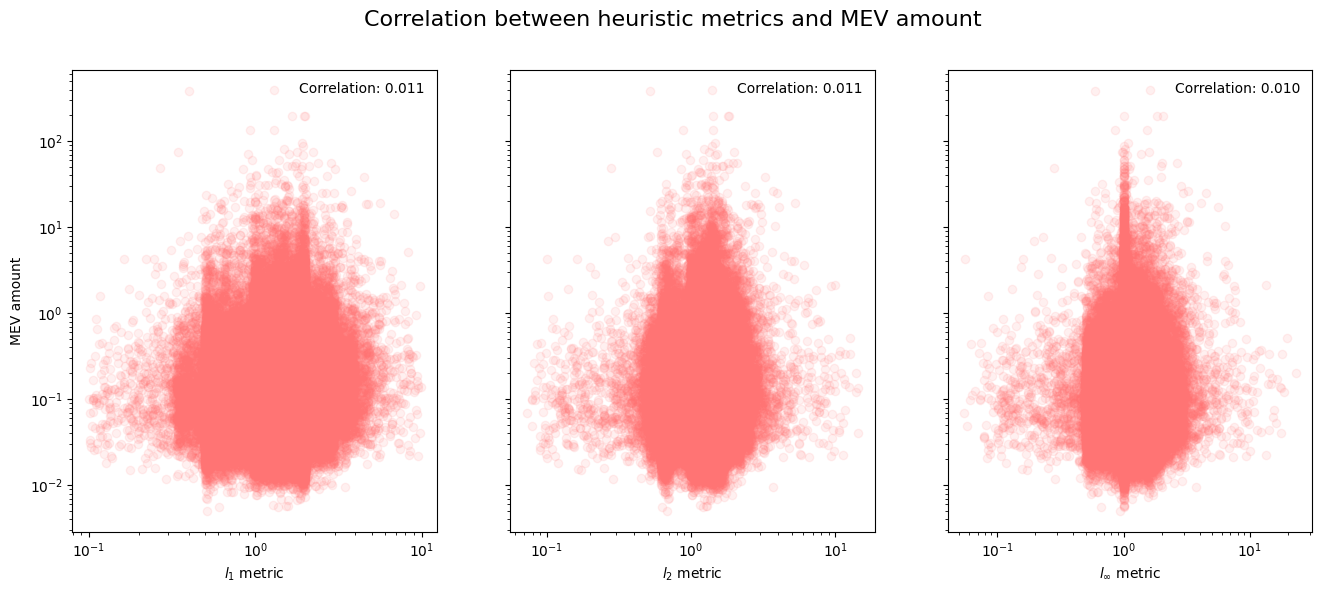

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
df_metric_mev = df_metric[df_metric.mev_boost == True]
df_metric_mev = df_metric_mev[df_metric_mev.metric_l1 != 1]
df_metric_mev = df_metric_mev[(df_metric_mev.metric_l1 < 1e1) & (df_metric_mev.metric_l1 > 1e-1)]

fig.suptitle("Correlation between heuristic metrics and MEV amount", fontsize=16)
plot_correlations(df_metric_mev, ax1, ax2, ax3)

### Plot some example price trajectories

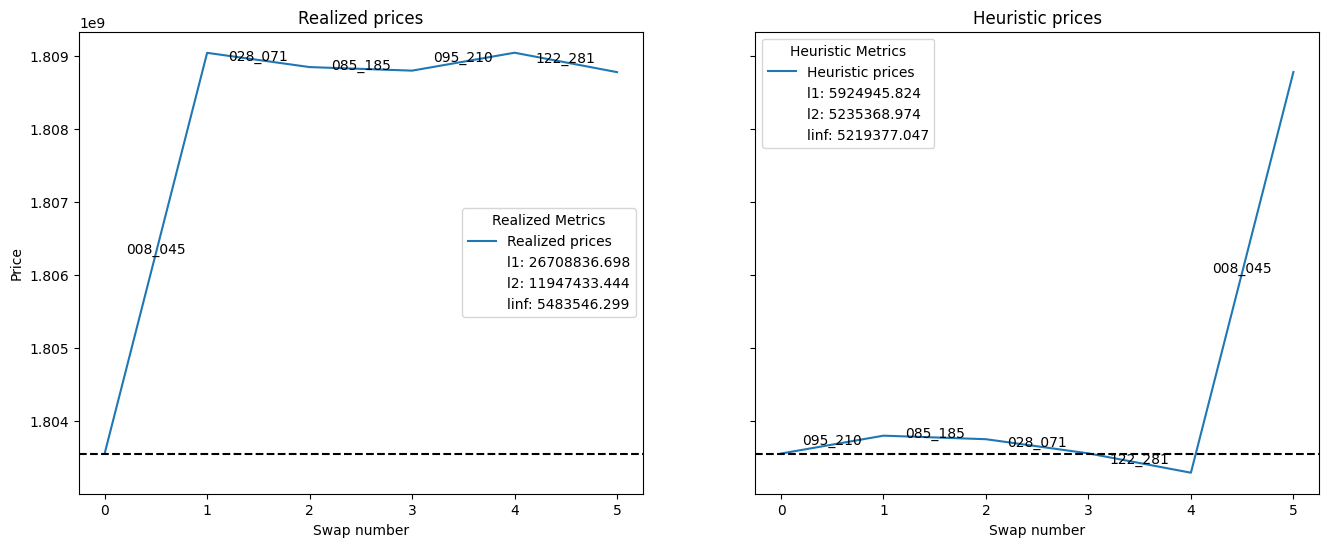

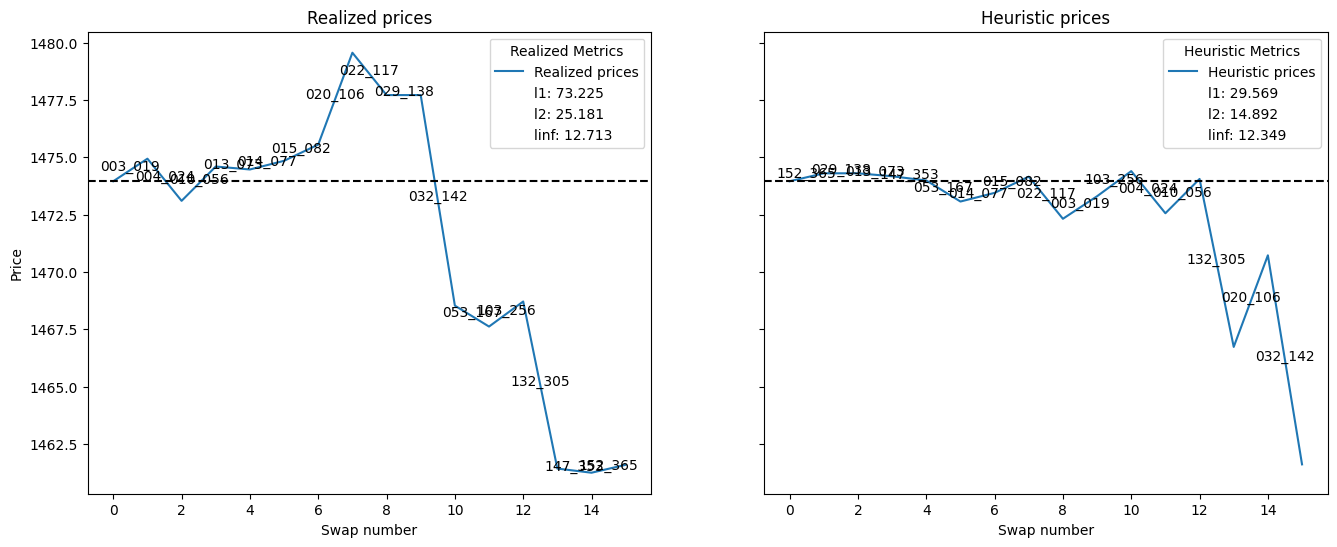

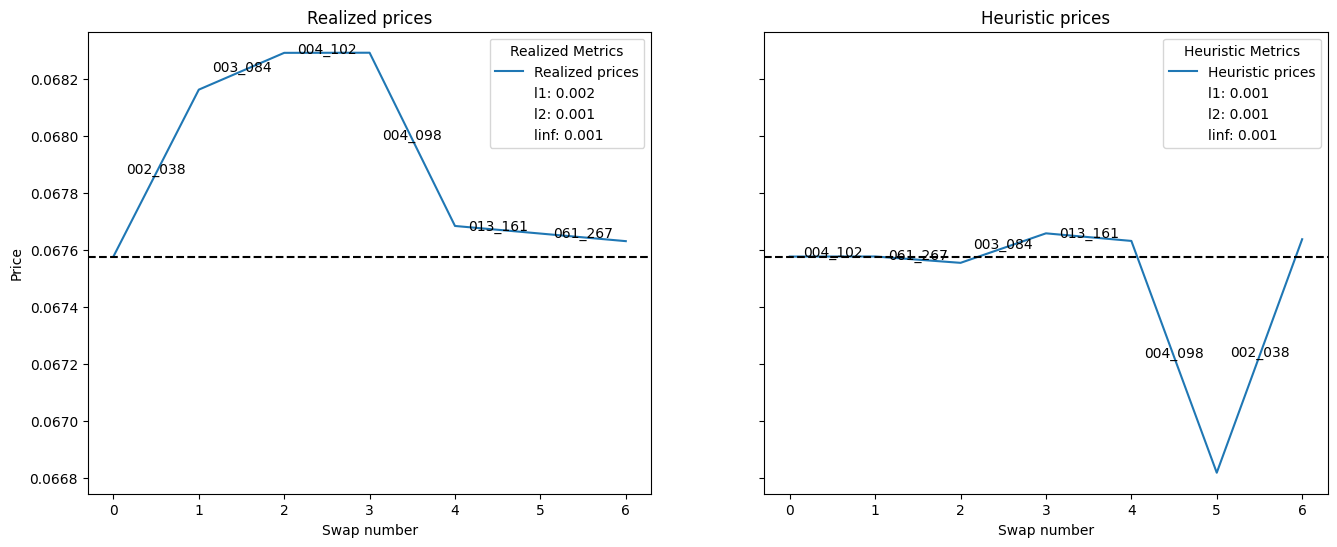

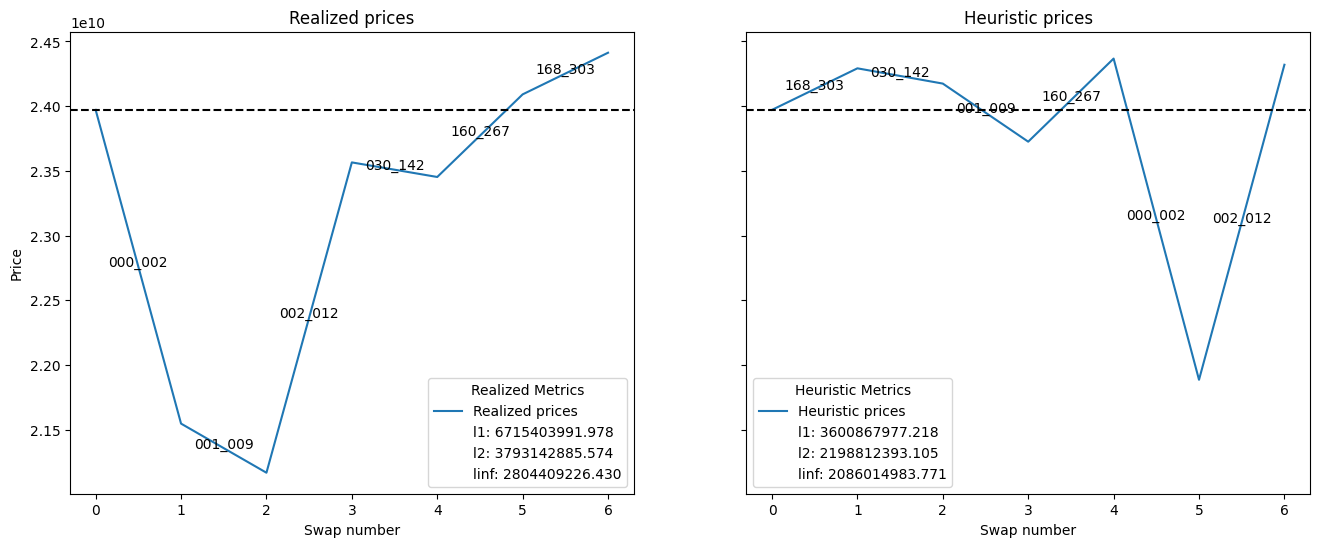

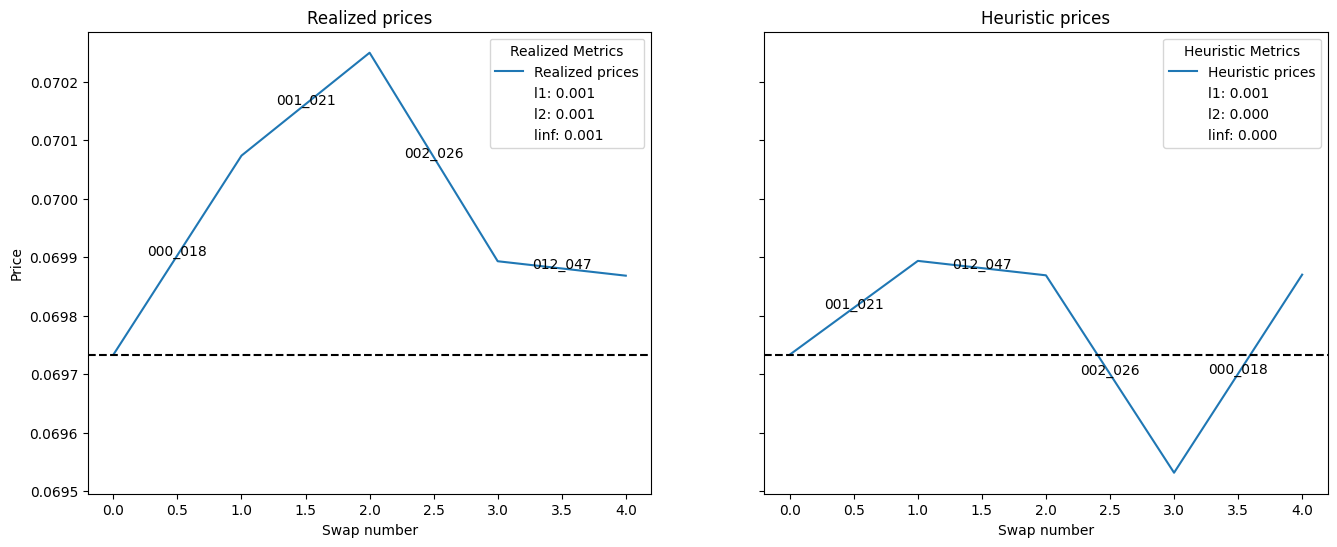

In [37]:
for i, row in df_metric[(df_metric.n_buys > 1) & (df_metric.n_sells > 1)].sample(n=5).iterrows():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    realized_prices = [row.baseline_price] + row.realized_prices
    heuristic_prices = [row.baseline_price] + row.volume_heur_prices
    ax1.plot(realized_prices, label="Realized prices")
    ax2.plot(heuristic_prices, label="Heuristic prices")

    # Add baseline price
    ax1.axhline(row.baseline_price, color='black', linestyle='--')
    ax2.axhline(row.baseline_price, color='black', linestyle='--')

    ax1.set_title("Realized prices")
    ax2.set_title("Heuristic prices")

    ax1.set_ylabel("Price")
    ax1.set_xlabel("Swap number")
    ax2.set_xlabel("Swap number")

# Create custom legend for ax1 (Realized Metrics)
    realized_legend_elements = [
        Line2D([0], [0], label="Realized prices"),
        Line2D([0], [0], color='white', label=f"l1: {row.realized_l1:.3f}"),
        Line2D([0], [0], color='white', label=f"l2: {row.realized_l2:.3f}"),
        Line2D([0], [0], color='white', label=f"linf: {row.realized_linf:.3f}"),
    ]
    ax1.legend(handles=realized_legend_elements, title="Realized Metrics")

    # Create custom legend for ax2 (Heuristic Metrics)
    heuristic_legend_elements = [
        Line2D([0], [0], label="Heuristic prices"),
        Line2D([0], [0], color='white', label=f"l1: {row.volume_heur_l1:.3f}"),
        Line2D([0], [0], color='white', label=f"l2: {row.volume_heur_l2:.3f}"),
        Line2D([0], [0], color='white', label=f"linf: {row.volume_heur_linf:.3f}"),
    ]
    ax2.legend(handles=heuristic_legend_elements, title="Heuristic Metrics")


    # Add swap labels for realized prices
    swap_labels = row.realized_order
    for j in range(len(swap_labels)):
        ax1.text(j + 0.5, (realized_prices[j] + realized_prices[j + 1]) / 2, swap_labels[j], ha='center')

    # Add swap labels for heuristic prices
    swap_labels = row.volume_heur_order
    for j in range(len(swap_labels)):
        ax2.text(j + 0.5, (heuristic_prices[j] + heuristic_prices[j + 1]) / 2, swap_labels[j], ha='center')
